In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_train = pd.read_excel('Train.xlsx')
df_test = pd.read_excel('Test.xlsx')

df_train_X = df_train[['AT', 'V', 'AP', 'RH']]
df_train_y = df_train[['PE']]
df_test_X = df_test[['AT', 'V', 'AP', 'RH']]
df_test_y = df_test[['PE']]

df_full = pd.concat([df_train, df_test], axis=0)
df_full.reset_index(drop=True, inplace=True)
df_full

AT      V       AP      RH      PE
0     10.54  34.03  1018.71   74.00  478.77
1      7.08  39.99  1010.55   91.44  482.83
2     14.49  41.16  1000.50   82.17  465.24
3     10.73  25.36  1009.35  100.15  469.43
4     22.88  63.91  1009.63   87.82  442.50
...     ...    ...      ...     ...     ...
9563  24.99  58.79  1016.37   67.16  439.20
9564  14.22  44.99  1012.00   75.28  460.53
9565  18.76  52.90  1016.27   64.70  458.26
9566  24.82  66.54  1010.00   60.36  440.88
9567  16.95  40.12  1012.59   87.87  457.05

[9568 rows x 5 columns]

# Feltáró adatelemzés

## Felesleges oszlopok, sorok

Feltételezésünk szerint az oszlopok mindegyikére szükségünk van a regresszió során, így nem dobunk egy egy oszlopot sem.

A potenciálisan eldobandó sorok:
- Hiányos értékeket tartalmazó sorok
- Hibás adatokat tartalmazó sorok

In [3]:
# hiányos adatokat tartalmazó sorok száma (train)
df_full.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

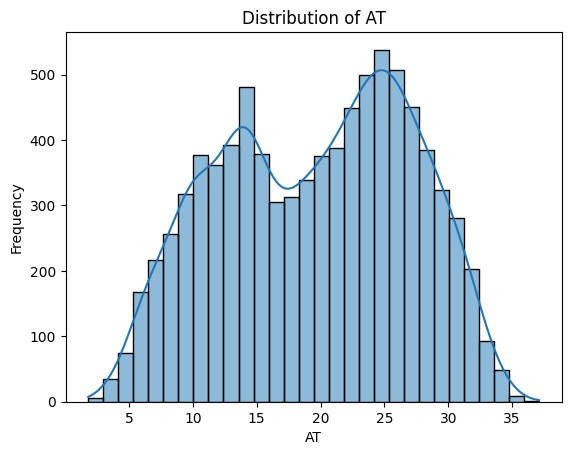

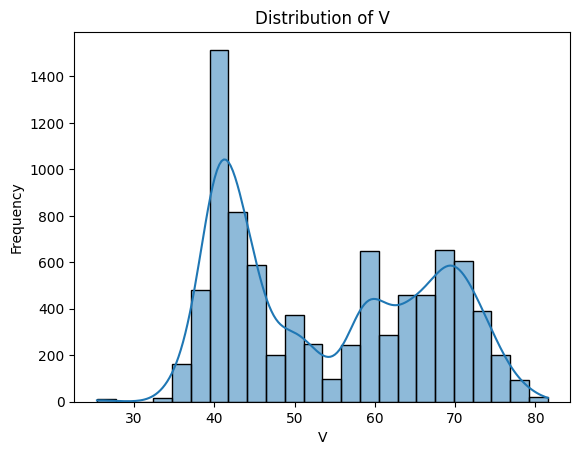

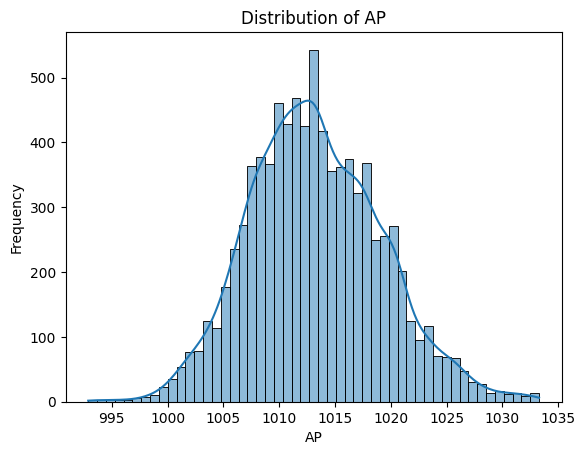

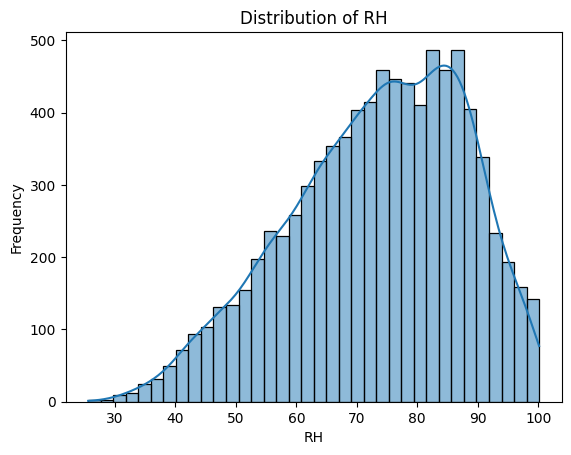

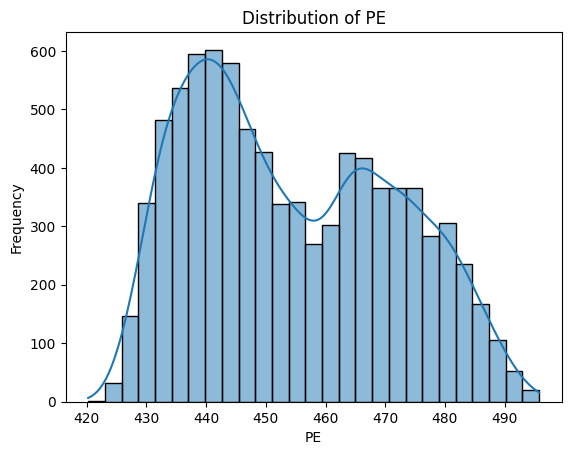

In [4]:
# Plotting the distribution of each column
for column in df_train.columns:
    sns.histplot(df_train[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

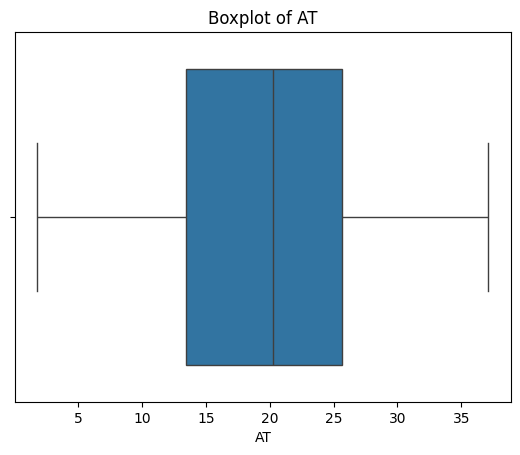

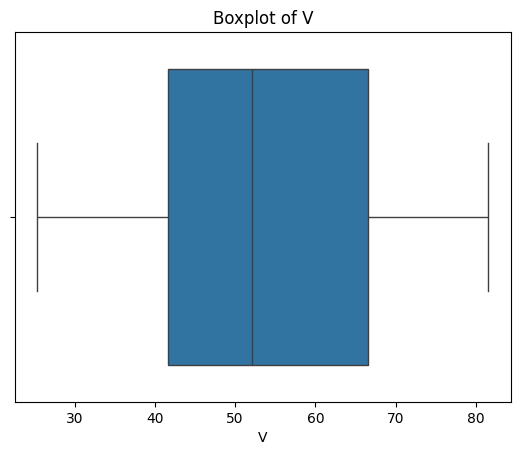

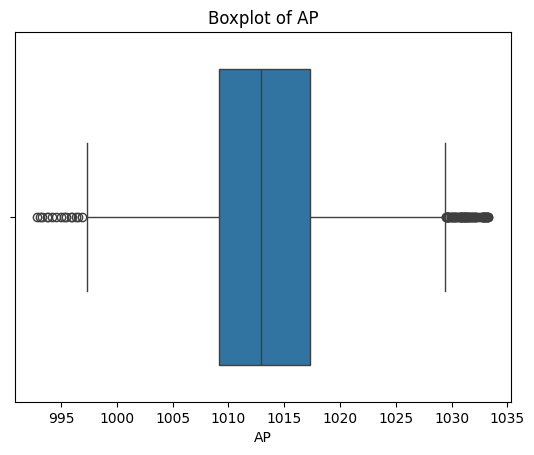

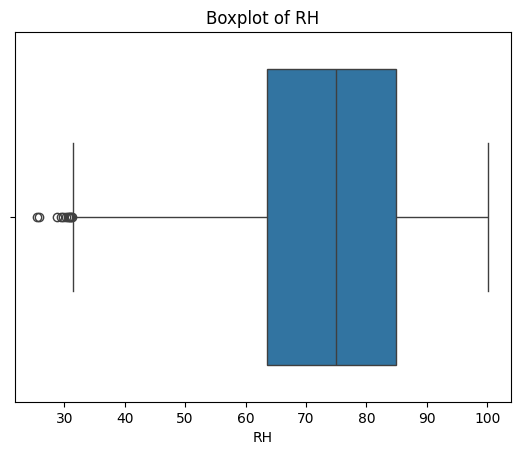

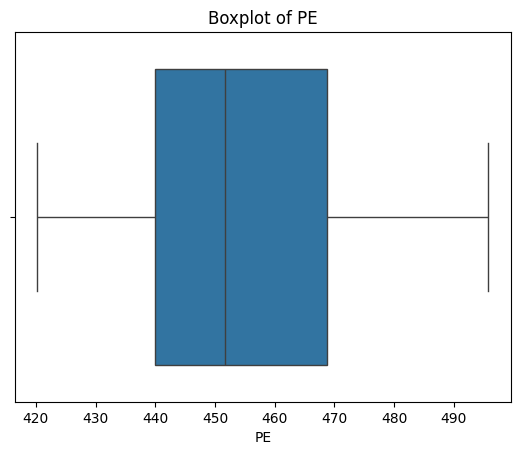

In [5]:
# Boxplots for each column
for column in df_train.columns:
    sns.boxplot(x=df_train[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

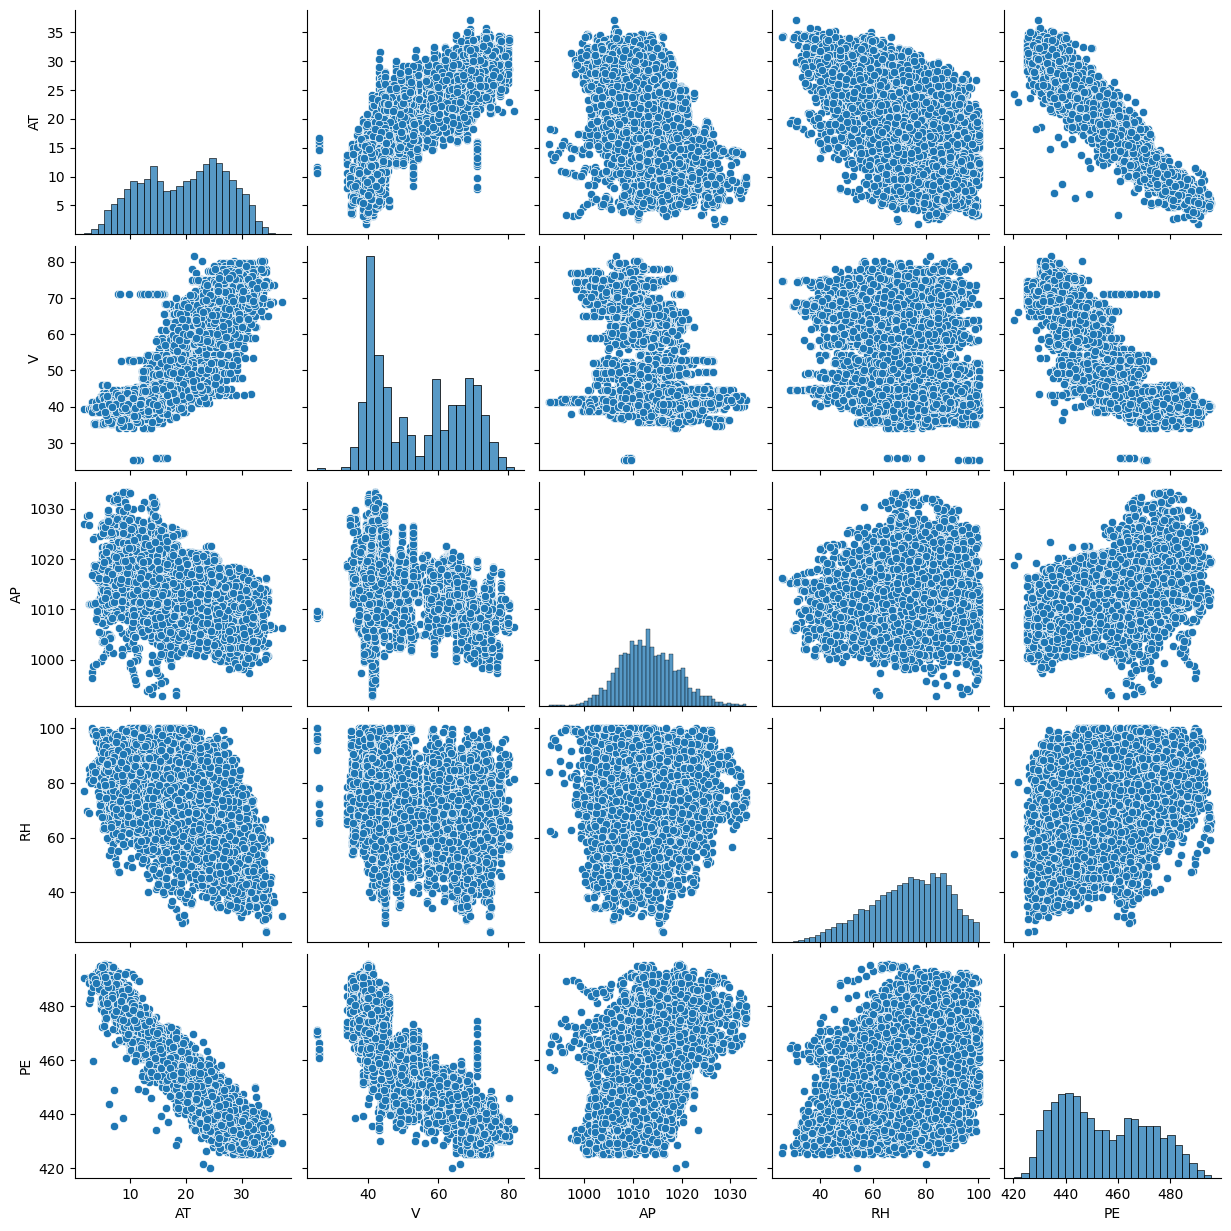

In [6]:
sns.pairplot(df_train)

137


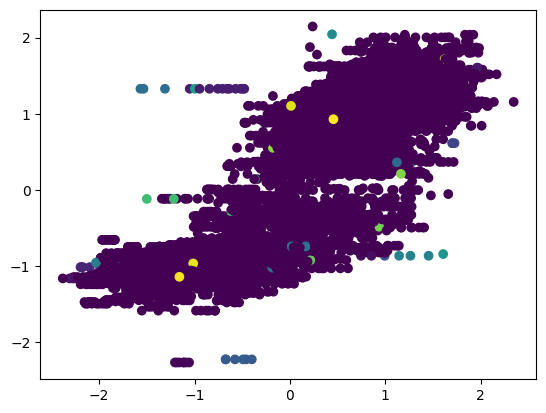

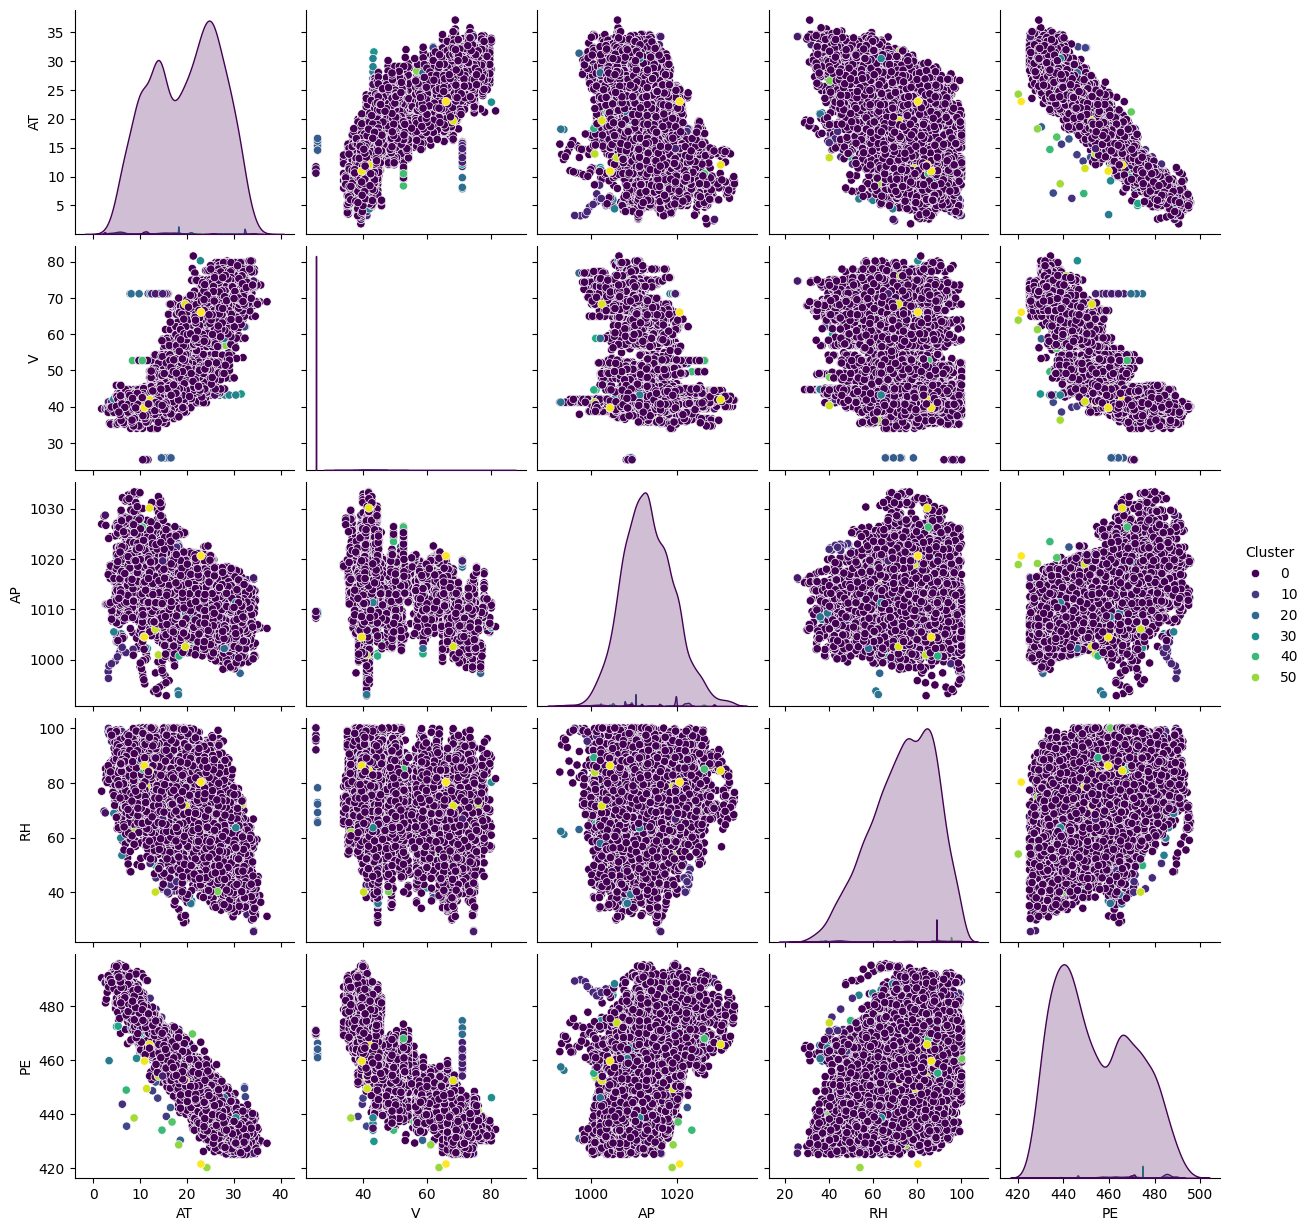

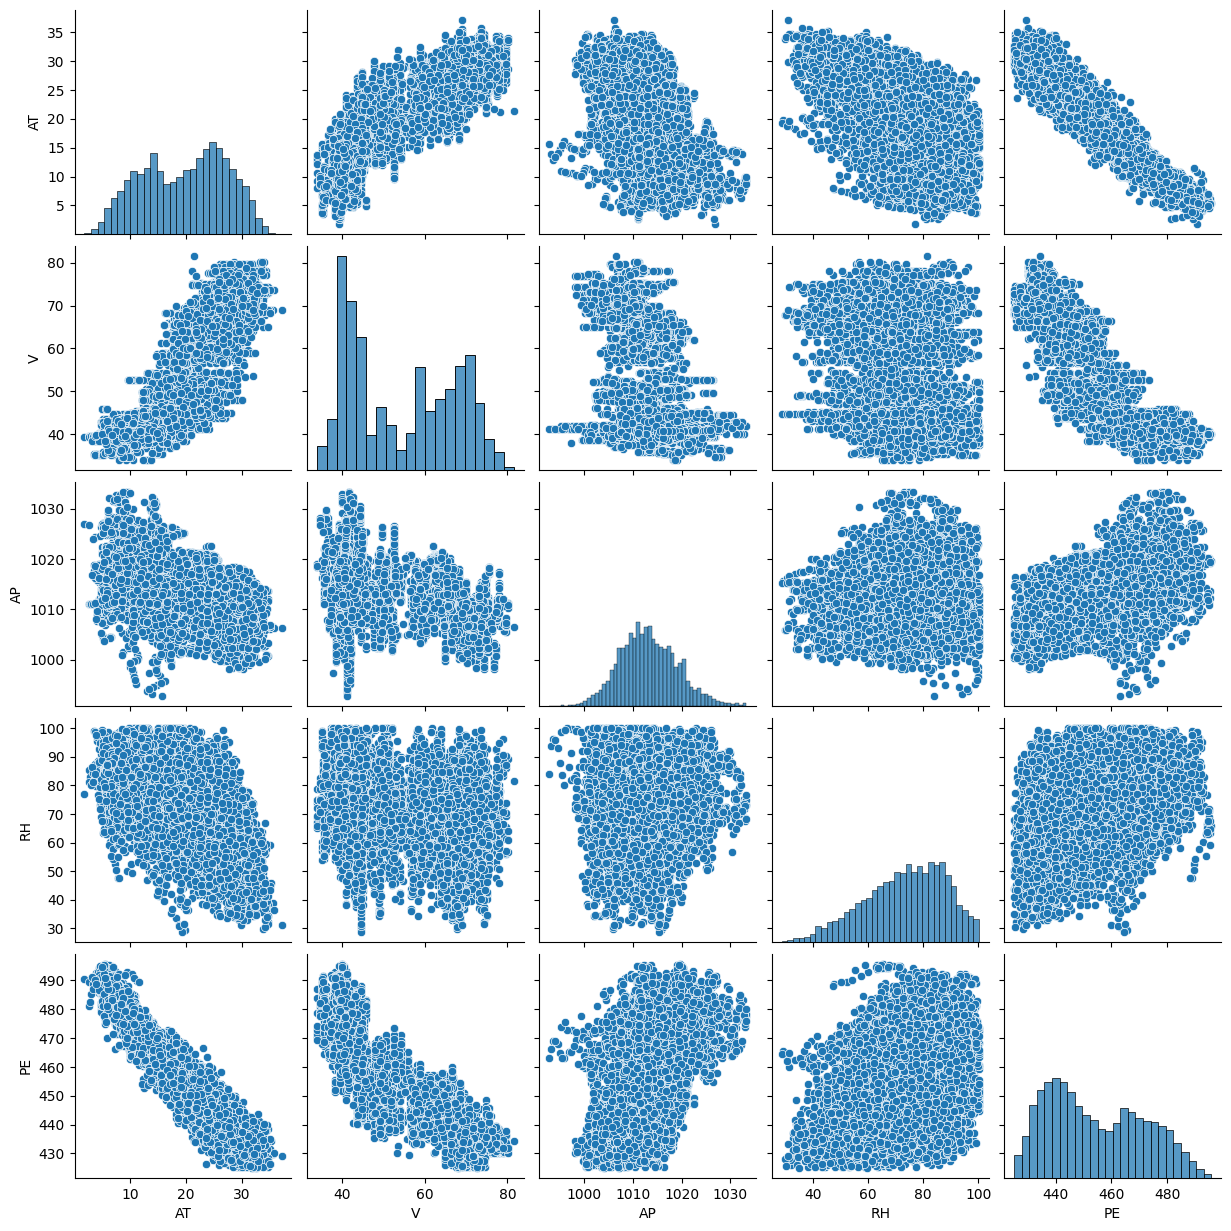

In [7]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load the dataset
df_dirty = df_train.copy()

# Select the columns you want to use for clustering
columns = df_dirty.columns

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(df_dirty[columns])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=1)
clusters = dbscan.fit_predict(data)

# Get the outlier groups
outlier_groups = df_dirty[clusters != 0]

# Visualize the clusters
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis')

# Add a column to the original dataframe with the cluster labels
df_dirty['Cluster'] = clusters

# Visualize the clusters on a pairplot
sns.pairplot(df_dirty, hue='Cluster', palette='viridis')

# New dataframe containing only rows in cluster -1
df_cleaned = df_dirty[df_dirty['Cluster'] == 0]

# drop the cluster column
df_cleaned = df_cleaned.drop(columns='Cluster')

# visualize the cleaned dataset with a simple pairplot
sns.pairplot(df_cleaned)

# number of removed rows
print(len(df_dirty) - len(df_cleaned))







In [8]:
# rearrange index of the cleaned dataset
df_cleaned.reset_index(drop=True, inplace=True)

# redefine the training dataset with the cleaned data
df_train = df_cleaned
df_train_X = df_train[['AT', 'V', 'AP', 'RH']]
df_train_y = df_train[['PE']]

df_train.corr().values

array([[ 1.        ,  0.85189578, -0.52253642, -0.54275518, -0.95140014],
       [ 0.85189578,  1.        , -0.43081364, -0.31715298, -0.87791514],
       [-0.52253642, -0.43081364,  1.        ,  0.10239665,  0.53560151],
       [-0.54275518, -0.31715298,  0.10239665,  1.        ,  0.39341128],
       [-0.95140014, -0.87791514,  0.53560151,  0.39341128,  1.        ]])

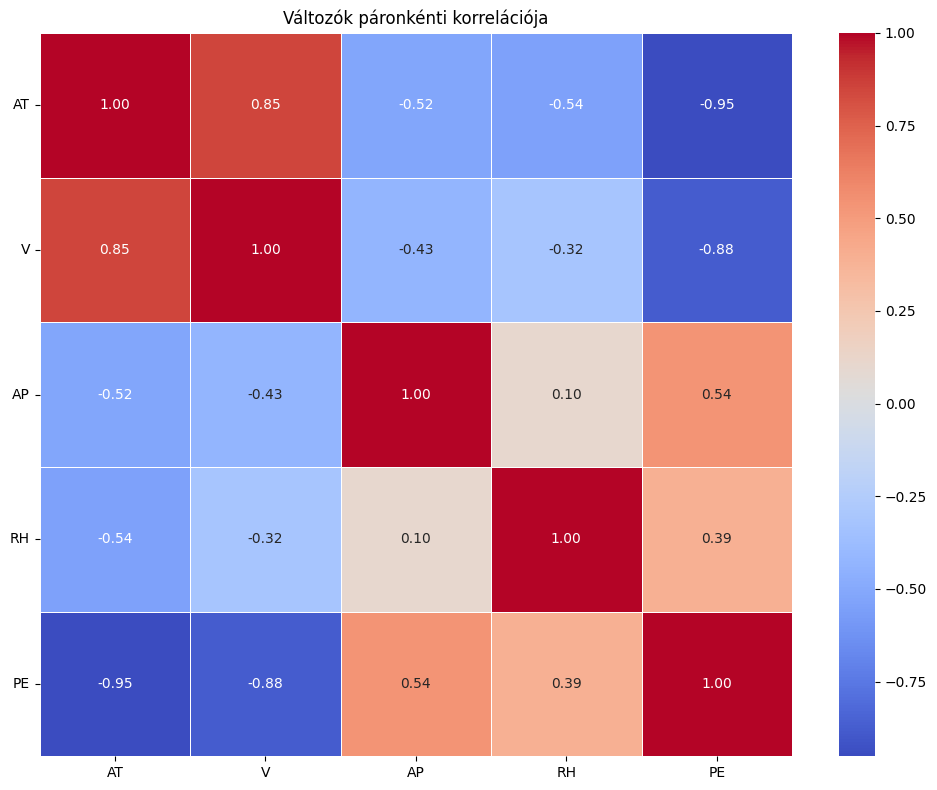

In [9]:
# Calculate correlation matrix
corr_matrix = df_train.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Változók páronkénti korrelációja')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Változó Szelekció vagy Dimenzió Redukció


A regressziós modellekhez használt bemeneti változók (input set-ek) meghatározása:
 - A 4 eredeti bemeneti változóból képzett részhalmazok.
 - PCA-val előállított input set(-ek)
 - PLS - Partial Least Squeares Regression - Mert ez eleve a független és függő változók kapcsolátának figyelembevételével végzi a változótranszformációt
 - Autoencoder-rel --> Korábbi módszerekből remélhetőleg látszik, hogy az 1, 2, és 3 változós input set-ek információtartalmai hogyan viszonyulnak egymáshoz. Az ezek közül jobban teljesítő méretű input set-ekre csinálok Autoencodert.
 
Nem használt dimenzió redukciós módszerek:
 - LDA: Ez cimkézési feladatok esetében ideális

### A 4 eredeti bemeneti változóból képzett részhalmazok

A részhalmazok a következők lesznek:

Egy elemű részhalmazok:
    Mivel a pairplot-okról és korrelációs mátrixból kiolvasható, hogy a Pe függő változót az AT határozza meg legpontosabban,
    így ezt az egy darab egy változót tartalmazó input set-et használom.
    - AT
    
Két, három és négy elemű részhalmazok:
    - Minden kombináció
    
    

In [10]:
### Train adatok különböző kombinációi
# 1 elemű
df_train_AT = df_train[['AT']]

# 2 elemű
df_train_AT_V = df_train[['AT', 'V']]
df_train_AT_AP = df_train[['AT', 'AP']]
df_train_AT_RH = df_train[['AT', 'RH']]
df_train_V_AP = df_train[['V', 'AP']]
df_train_V_RH = df_train[['V', 'RH']]
df_train_AP_RH = df_train[['AP', 'RH']]

# 3 elemű
df_train_AT_V_AP = df_train[['AT', 'V', 'AP']]
df_train_AT_V_RH = df_train[['AT', 'V', 'RH']]
df_train_AT_AP_RH = df_train[['AT', 'AP', 'RH']]
df_train_V_AP_RH = df_train[['V', 'AP', 'RH']]

### Test adatok különböző kombinációi
# 1 elemű
df_test_AT = df_test[['AT']]

# 2 elemű
df_test_AT_V = df_test[['AT', 'V']]
df_test_AT_AP = df_test[['AT', 'AP']]
df_test_AT_RH = df_test[['AT', 'RH']]
df_test_V_AP = df_test[['V', 'AP']]
df_test_V_RH = df_test[['V', 'RH']]
df_test_AP_RH = df_test[['AP', 'RH']]

# 3 elemű
df_test_AT_V_AP = df_test[['AT', 'V', 'AP']]
df_test_AT_V_RH = df_test[['AT', 'V', 'RH']]
df_test_AT_AP_RH = df_test[['AT', 'AP', 'RH']]
df_test_V_AP_RH = df_test[['V', 'AP', 'RH']]


### PCA

A dimenzióredukciós technikákhoz standardizálnunk kell a bemeneti változókat.

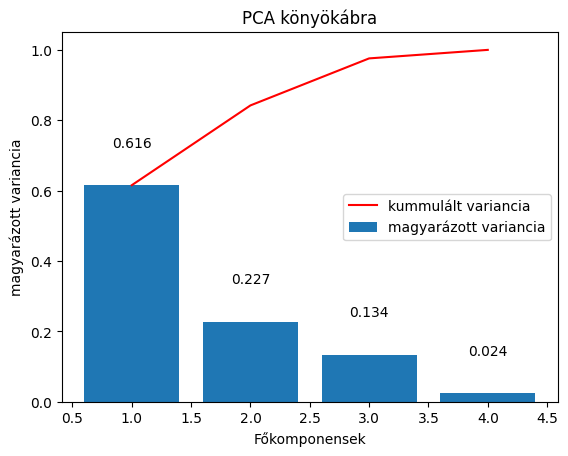

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# standard scaling of independent variables
sc = StandardScaler()
df_train_X_sc = sc.fit_transform(df_train_X)
df_test_X_sc = sc.fit_transform(df_test_X)

# PCA
pca = PCA(n_components=4)
pca.fit(df_train_X_sc)

plt.plot(range(1, df_train_X_sc.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_), label='kummulált variancia', color='red')
plt.bar(range(1, df_train_X_sc.shape[1] + 1), pca.explained_variance_ratio_, label='magyarázott variancia')
plt.title('PCA könyökábra')
plt.xlabel('Főkomponensek')
plt.ylabel('magyarázott variancia')
plt.legend(loc="right")
for bar, value in enumerate(pca.explained_variance_ratio_):
    plt.text(bar+1, value+0.1, str(round(value, 3)), ha='center', va='bottom')


Az első három főkomponens mindegyike relatív fontos, a negyedik viszont elhanyagolható, így a modellek tanításához az első három főkomponenshez tartozó értékeket használom.

In [12]:
# PCA 3 dimenzióra
pca = PCA(n_components=3)
pca.fit(df_train_X_sc)

df_train_PCA3_X = pd.DataFrame(pca.transform(df_train_X_sc), columns=['PC1', 'PC2', 'PC3'])
df_test_PCA3_X = pd.DataFrame(pca.transform(df_test_X_sc), columns=['PC1', 'PC2', 'PC3'])

df_train_PCA3 = df_train_PCA3_X.copy()
df_train_PCA3['PE'] = df_train['PE']

In [13]:
pca.components_

array([[ 0.61288652,  0.55981235, -0.41035421, -0.37761048],
       [-0.0481525 ,  0.10221143, -0.63539992,  0.76387244],
       [-0.17075477, -0.59217598, -0.63774336, -0.46201063]])

### PLS

A PLS egy olyan dimenzió redukciós technika, amely figyelembe veszi a felaadt regressziós mivoltát és igyekszik megőrizni a független és függő változók közötti kapcsolatokat. Regressziós feladathoz ezért ezt a módszert is kipróbáltam. 

Ebben az esetben is skálázott független változókkal dolgoztam. 1-től 4 komponensig néztem meg a PLS modell teljesitményét a tanitóhalmazon. A kiértékeléshez 5-fold keresztvalidációt és R^2, MAE és RMSE pontszámot használtam.

   n_Components      RMSE       MAE        R2
0           4.0  4.384632  3.577893  0.934091
1           3.0  4.783133  3.843594  0.921558
2           2.0  5.071093  4.078214  0.911833
3           1.0  6.134551  4.954332  0.871027


(0.8, 0.95)

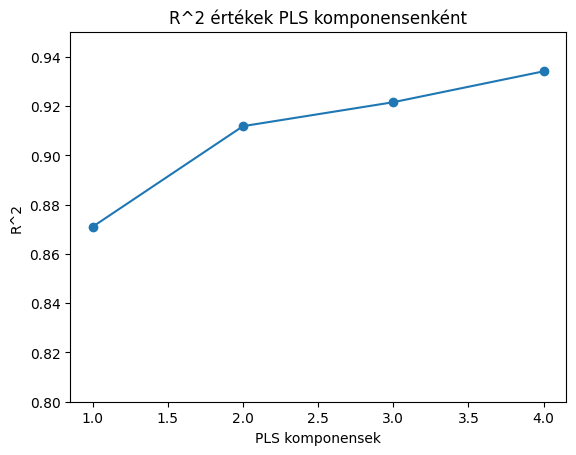

In [14]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize a list to store cross-validation scores
cv_scores = pd.DataFrame(columns=['n_Components', 'RMSE', 'MAE', 'R2'])

# Define the range of components to try
components_range = range(1, 5)  # Example range, adjust as needed

# Perform k-fold cross-validation for each number of components
for n_components in components_range:
    pls = PLSRegression(n_components=n_components)
    r2_scores = cross_val_score(pls, df_train_X_sc, df_train_y, cv=5, scoring='r2')  # Using R^2 score as the metric
    mae_scores = -cross_val_score(pls, df_train_X_sc, df_train_y, cv=5, scoring='neg_mean_absolute_error')  # Using MAE score as the metric
    rmse_scores = -cross_val_score(pls, df_train_X_sc, df_train_y, cv=5, scoring='neg_root_mean_squared_error')  # Using RMSE score as the metric
    cv_scores.loc[-1] = [n_components, rmse_scores.mean(), mae_scores.mean(), r2_scores.mean()] # adding a row
    cv_scores.index = cv_scores.index + 1  # shifting index
    cv_scores = cv_scores.sort_index()  # sorting by index

print(cv_scores)


# Plotting the R-squared scores for each number of components
plt.plot(cv_scores['n_Components'].to_list(), cv_scores['R2'].to_list(), marker='o')
plt.xlabel('PLS komponensek')
plt.ylabel('R^2')
plt.title('R^2 értékek PLS komponensenként')
# set y range to 0-1
plt.ylim(0.8, 0.95)


A keresztvalidáció eredménye az, hogy a PLS modell 4 komponenssel adja a legpontosabb eredményeket r^2, MAE és RMSE esetén is. Ez azt jelenti, hogy valósznűleg nem éri meg PLS regressziót alkalmazni, de ettől függetlenül én elkésztettem a 3 és 4 komponenses PLS modelleket is.

In [15]:
# 2 komponens
pls_2comp = PLSRegression(n_components=2)
pls_2comp.fit(df_train_X_sc, df_train_y)
y_PLS2 = pls_2comp.predict(df_train_X_sc)
r2_PLS2_train = pls_2comp.score(df_train_X_sc, df_train_y)
r2_PLS2_test = pls_2comp.score(df_test_X_sc, df_test_y)

print(r2_PLS2_train, r2_PLS2_test)

# 3 komponens
pls_3comp = PLSRegression(n_components=3)
pls_3comp.fit(df_train_X_sc, df_train_y)
y_PLS3 = pls_3comp.predict(df_train_X_sc)
r2_PLS3_train = pls_3comp.score(df_train_X_sc, df_train_y)
r2_PLS3_test = pls_3comp.score(df_test_X_sc, df_test_y)

print(r2_PLS3_train, r2_PLS3_test)

# 4 komponens
pls_4comp = PLSRegression(n_components=4)
pls_4comp.fit(df_train_X_sc, df_train_y)
y_PLS4 = pls_4comp.predict(df_train_X_sc)
r2_PLS4_train = pls_4comp.score(df_train_X_sc, df_train_y)
r2_PLS4_test = pls_4comp.score(df_test_X_sc, df_test_y)

print(r2_PLS4_train, r2_PLS4_test)

df_train_PLS3_X_sc = pls_3comp.transform(df_train_X_sc)
df_train_PLS4_X_sc = pls_4comp.transform(df_train_X_sc)

df_test_PLS3_X_sc = pls_3comp.transform(df_test_X_sc)
df_test_PLS4_X_sc = pls_4comp.transform(df_test_X_sc)

0.9119215962804825 0.8999826162343414
0.921676340504423 0.9111182136897987
0.9342240038955464 0.9264326205967056


A teszt adatsoron is a 4 komponensű PLS regressziós modell adta a legjobb eredményeket.

### A következő bemeneti adatokra fogok tehát modellt illeszteni:
* 1D: AT
* 2D: minden két elemű részhalmaz az eredeti bemeneti változókból
* 3D: minden három elemű részhalmaz az eredeti bemeneti változókból, PCA, PLS3
* 4D: minden eredeti változó, PLS4

In [16]:
input_sets = [
    # 1D
    {'train': df_train_AT, 'test': df_test_AT, 'name': 'AT'},
    # 2D
    {'train': df_train_AT_V, 'test': df_test_AT_V, 'name': 'AT_V'},
    {'train': df_train_AT_AP, 'test': df_test_AT_AP, 'name': 'AT_AP'},
    {'train': df_train_AT_RH, 'test': df_test_AT_RH, 'name': 'AT_RH'},
    {'train': df_train_V_AP, 'test': df_test_V_AP, 'name': 'V_AP'},
    {'train': df_train_V_RH, 'test': df_test_V_RH, 'name': 'V_RH'},
    {'train': df_train_AP_RH, 'test': df_test_AP_RH, 'name': 'AP_RH'},
    # 3D
    {'train': df_train_AT_V_AP, 'test': df_test_AT_V_AP, 'name': 'AT_V_AP'},
    {'train': df_train_AT_V_RH, 'test': df_test_AT_V_RH, 'name': 'AT_V_RH'},
    {'train': df_train_AT_AP_RH, 'test': df_test_AT_AP_RH, 'name': 'AT_AP_RH'},
    {'train': df_train_V_AP_RH, 'test': df_test_V_AP_RH, 'name': 'V_AP_RH'},

    {'train': df_train_PCA3_X, 'test': df_test_PCA3_X, 'name': 'PCA3'},
    {'train': df_train_PLS3_X_sc, 'test': df_test_PLS3_X_sc, 'name': 'PLS3'},
    # 4D
    {'train': df_train_X, 'test': df_test_X, 'name': 'Full'},
    {'train': df_train_PLS4_X_sc, 'test': df_test_PLS4_X_sc, 'name': 'PLS4'}
]

### Sztenderdizált adatsorok
Bizonyosregressziós modelleknél szükség van a független változók sztenderdizálására. Emiatt létrehozom a bemeneti adatsorok sztenderdizált verzióit is.

In [17]:
# standardized df_train_AT input set
sc = StandardScaler()

# 1D
df_train_AT_sc = sc.fit_transform(df_train_AT)
df_test_AT_sc = sc.transform(df_test_AT)

# 2D
df_train_AT_V_sc = sc.fit_transform(df_train_AT_V)
df_test_AT_V_sc = sc.transform(df_test_AT_V)
df_train_AT_AP_sc = sc.fit_transform(df_train_AT_AP)
df_test_AT_AP_sc = sc.transform(df_test_AT_AP)
df_train_AT_RH_sc = sc.fit_transform(df_train_AT_RH)
df_test_AT_RH_sc = sc.transform(df_test_AT_RH)
df_train_V_AP_sc = sc.fit_transform(df_train_V_AP)
df_test_V_AP_sc = sc.transform(df_test_V_AP)
df_train_V_RH_sc = sc.fit_transform(df_train_V_RH)
df_test_V_RH_sc = sc.transform(df_test_V_RH)
df_train_AP_RH_sc = sc.fit_transform(df_train_AP_RH)
df_test_AP_RH_sc = sc.transform(df_test_AP_RH)

# 3D
df_train_AT_V_AP_sc = sc.fit_transform(df_train_AT_V_AP)
df_test_AT_V_AP_sc = sc.transform(df_test_AT_V_AP)
df_train_AT_V_RH_sc = sc.fit_transform(df_train_AT_V_RH)
df_test_AT_V_RH_sc = sc.transform(df_test_AT_V_RH)
df_train_AT_AP_RH_sc = sc.fit_transform(df_train_AT_AP_RH)
df_test_AT_AP_RH_sc = sc.transform(df_test_AT_AP_RH)
df_train_V_AP_RH_sc = sc.fit_transform(df_train_V_AP_RH)
df_test_V_AP_RH_sc = sc.transform(df_test_V_AP_RH)

# 4D
df_train_X_sc = sc.fit_transform(df_train_X)
df_test_X_sc = sc.transform(df_test_X)


input_sets_sc = [
    # 1D
    {'train': df_train_AT_sc, 'test': df_test_AT_sc, 'name': 'AT_sc'},
    # 2D
    {'train': df_train_AT_V_sc, 'test': df_test_AT_V_sc, 'name': 'AT_V_sc'},
    {'train': df_train_AT_AP_sc, 'test': df_test_AT_AP_sc, 'name': 'AT_AP_sc'},
    {'train': df_train_AT_RH_sc, 'test': df_test_AT_RH_sc, 'name': 'AT_RH_sc'},
    {'train': df_train_V_AP_sc, 'test': df_test_V_AP_sc, 'name': 'V_AP_sc'},
    {'train': df_train_V_RH_sc, 'test': df_test_V_RH_sc, 'name': 'V_RH_sc'},
    {'train': df_train_AP_RH_sc, 'test': df_test_AP_RH_sc, 'name': 'AP_RH_sc'},
    # 3D
    {'train': df_train_AT_V_AP_sc, 'test': df_test_AT_V_AP_sc, 'name': 'AT_V_AP_sc'},
    {'train': df_train_AT_V_RH_sc, 'test': df_test_AT_V_RH_sc, 'name': 'AT_V_RH_sc'},
    {'train': df_train_AT_AP_RH_sc, 'test': df_test_AT_AP_RH_sc, 'name': 'AT_AP_RH_sc'},
    {'train': df_train_V_AP_RH_sc, 'test': df_test_V_AP_RH_sc, 'name': 'V_AP_RH_sc'},

    {'train': df_train_PCA3_X, 'test': df_test_PCA3_X, 'name': 'PCA3'},
    {'train': df_train_PLS3_X_sc, 'test': df_test_PLS3_X_sc, 'name': 'PLS3'},
    # 4D
    {'train': df_train_X_sc, 'test': df_test_X_sc, 'name': 'Full_sc'},
    {'train': df_train_PLS4_X_sc, 'test': df_test_PLS4_X_sc, 'name': 'PLS4'}
]
    

## Regressziós modellek

Több regressziós modell teljesítményét is meghatározom a feladat során. A különböző input set-eken tanított modell típusok:
 - Lineáris regresszió
 - Polinomiális regresszió
 - KNN
 - decision tree
 - random forest
 - Suppert Vector regression
 - neural network

A különböző regressziós modellek teljesítményeit a különböző bemeneteken egy közös dataframe-ben tárolom el. Minden regressziós modell + bemenet kombinációhoz eltárolom az R^2, RMSE és MAE értékeket

In [18]:
df_results = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

### Lineáris Regresszió
Ez egy nagyon egyszerű modell, nincsenek hiperparamétereink, ezért nem szükséges validációs adathalmazt definiálni.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from IPython.display import display

df_results_linear_regression = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

def linear_regression(input_set: dict):
    # print(input_set['name'])
    df_train = input_set['train']
    df_test = input_set['test']

    lin_reg = LinearRegression()
    lin_reg.fit(df_train, df_train_y)

    df_train_y_lin_reg = lin_reg.predict(df_train)
    df_test_y_lin_reg = lin_reg.predict(df_test)

    lin_reg_result =       {
        'model': 'Linear Regression',
        'input': input_set['name'],
        'R2_train': r2_score(df_train_y, df_train_y_lin_reg),
        'R2_test': r2_score(df_test_y, df_test_y_lin_reg), 
        'RMSE_train': math.sqrt(mean_squared_error(df_train_y, df_train_y_lin_reg)), 
        'RMSE_test': math.sqrt(mean_squared_error(df_test_y, df_test_y_lin_reg)), 
        'MAE_train': mean_absolute_error(df_train_y, df_train_y_lin_reg), 
        'MAE_test': mean_absolute_error(df_test_y, df_test_y_lin_reg)
        }

    return pd.DataFrame([lin_reg_result])

for input_set in input_sets:
    lin_reg_res = linear_regression(input_set)
    df_results_linear_regression = pd.concat([df_results_linear_regression, lin_reg_res], ignore_index=True)

# display(df_results_linear_regression)

df_results = pd.concat([df_results, df_results_linear_regression],  ignore_index=True)




C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\3494449330.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_linear_regression = pd.concat([df_results_linear_regression, lin_reg_res], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\3494449330.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_results_linear_regression],  ignore_index=True)


### Ridge és Lasso regression
A Lineáris Regressziós modell akkor képes túltanulni, ha a tanítóhalmazban a független változók száma túl nagy az adatsorokhoz képest. Ez a veszély esetünkben nem áll fenn, hiszen mindössze négy független változónk van. Ezért nincs szükségünk a Ridge és Lasso regressziós technikákra.

### Polynomial Regression
Én másodrendű polinomiális regressziót alkalmazok

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

poly_reg = PolynomialFeatures(degree = 2)

df_results_polinomial_regression = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

# polynomial regression for all input sets
for input_set in input_sets:
    df_train_pol = input_set['train']
    df_test_pol = input_set['test']
    X_poly = poly_reg.fit_transform(df_train_pol)
    regressor_pol1 = LinearRegression()
    regressor_pol1.fit(X_poly, df_train_y)
    y_poli_pred_train = regressor_pol1.predict(X_poly)

    r2_pol1_train = r2_score(df_train_y, y_poli_pred_train)
    rmse_pol1_train = math.sqrt(mean_squared_error(df_train_y, y_poli_pred_train))
    mae_pol1_train = mean_absolute_error(df_train_y, y_poli_pred_train)

    X_poly_test = poly_reg.transform(df_test_pol)
    y_poli_pred_test = regressor_pol1.predict(X_poly_test)

    r2_pol1_test = r2_score(df_test_y, y_poli_pred_test)
    rmse_pol1_test = math.sqrt(mean_squared_error(df_test_y, y_poli_pred_test))
    mae_pol1_test = mean_absolute_error(df_test_y, y_poli_pred_test)

    pol1_result = {
        'model': 'Polynomial Regression (degree=2)',
        'input': input_set['name'],
        'R2_train': r2_pol1_train,
        'R2_test': r2_pol1_test,
        'RMSE_train': rmse_pol1_train,
        'RMSE_test': rmse_pol1_test,
        'MAE_train': mae_pol1_train,
        'MAE_test': mae_pol1_test
    }

    df_results_polinomial_regression = pd.concat([df_results_polinomial_regression, pd.DataFrame([pol1_result])], ignore_index=True)

df_results = pd.concat([df_results, df_results_polinomial_regression], ignore_index=True)

C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\3909480854.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_polinomial_regression = pd.concat([df_results_polinomial_regression, pd.DataFrame([pol1_result])], ignore_index=True)


###

### KNN

A KNN regresszió távolság alapú technika, így a sztenderdizált bemeneti adatsorokkal dolgozom.

C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\1309586935.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_knn = pd.concat([df_results_knn, knn_res], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\1309586935.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_knn = pd.concat([df_results_knn, knn_res], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\1309586935.py:39: FutureWarning: The behavior of DataFrame concatenation wit

Text(0.5, 1.0, 'KNN regresszió - A legjobban teljesítő bemeneti adatsorhoz tartozó R^2 értékek a K függvényében')

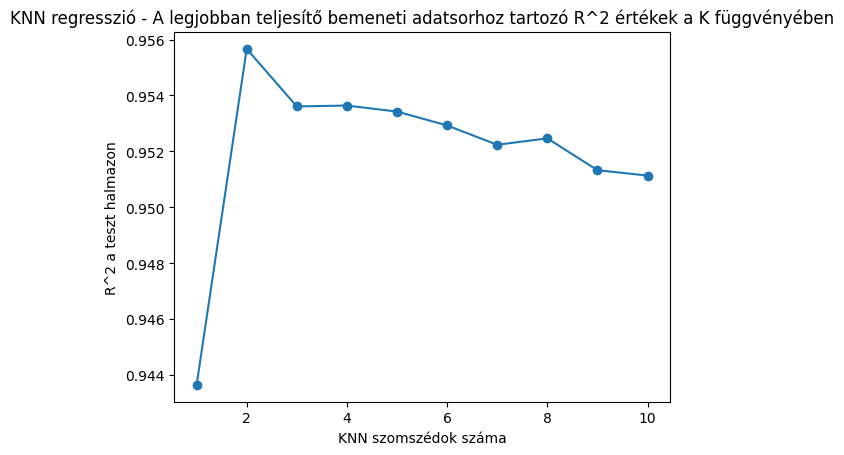

In [21]:
from sklearn.neighbors import KNeighborsRegressor

df_results_knn = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

# function of KNN regression for all input sets
def knn_regression(input_set: dict, n_neighbors: int):
    df_train_knn = input_set['train']
    df_test_knn = input_set['test']

    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(df_train_knn, df_train_y)

    df_train_y_knn_pred = knn.predict(df_train_knn)
    df_test_y_knn_pred = knn.predict(df_test_knn)

    knn_result = {
        'model': f'KNN Regression (n_neighbors={n_neighbors})',
        'input': input_set['name'],
        'R2_train': r2_score(df_train_y, df_train_y_knn_pred),
        'R2_test': r2_score(df_test_y, df_test_y_knn_pred),
        'RMSE_train': math.sqrt(mean_squared_error(df_train_y, df_train_y_knn_pred)),
        'RMSE_test': math.sqrt(mean_squared_error(df_test_y, df_test_y_knn_pred)),
        'MAE_train': mean_absolute_error(df_train_y, df_train_y_knn_pred),
        'MAE_test': mean_absolute_error(df_test_y, df_test_y_knn_pred)
    }

    return pd.DataFrame([knn_result])

# function to return element with highest R2 score from a dataframe
def get_max_r2(df: pd.DataFrame):
    return df[df['R2_test']==df['R2_test'].max()]

# function of KNN regression for all input sets
def knn_regression_all(input_sets: list, n_neighbors: int):
    df_results_knn = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

    for input_set in input_sets:
        knn_res = knn_regression(input_set, n_neighbors)
        df_results_knn = pd.concat([df_results_knn, knn_res], ignore_index=True)

    return df_results_knn


# for n_neighbors in range(1, 11) do KNN regression for all scaled input sets
knn_results_map_r2 = {}
knn_results_map = {}
for n_neighbors in range(1, 11):
    knn_res = knn_regression_all(input_sets_sc, n_neighbors)
    best_knn_res = get_max_r2(knn_res)
    knn_results_map[n_neighbors] = best_knn_res
    best_r2 = best_knn_res['R2_test']
    knn_results_map_r2[n_neighbors] = best_r2

# plot the best R2 score for each n_neighbors
plt.plot(knn_results_map_r2.keys(), knn_results_map_r2.values(), marker='o')
plt.xlabel('KNN szomszédok száma')
plt.ylabel('R^2 a teszt halmazon')
plt.title('KNN regresszió - A legjobban teljesítő bemeneti adatsorhoz tartozó R^2 értékek a K függvényében')


In [22]:
# concatenate the best results for each n_neighbors
df_best_knn_results = pd.concat(knn_results_map.values(), ignore_index=True)


KNN works best with K=2 neighbours

In [23]:
# calculate KNN regression for 2 neighbors
df_results_knn_2 = knn_regression_all(input_sets_sc, 2)
df_results = pd.concat([df_results, df_results_knn_2], ignore_index=True)

C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\1309586935.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_knn = pd.concat([df_results_knn, knn_res], ignore_index=True)


### Decision Tree

In [24]:
# function of Decision Tree regression for all input sets
from sklearn.tree import DecisionTreeRegressor

def decision_tree_regression(input_set: dict, max_depth: int):
    df_train_dt = input_set['train']
    df_test_dt = input_set['test']

    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=1)
    dt.fit(df_train_dt, df_train_y)

    df_train_y_dt_pred = dt.predict(df_train_dt)
    df_test_y_dt_pred = dt.predict(df_test_dt)

    dt_result = {
        'model': f'Decision Tree Regression (max_depth={max_depth})',
        'input': input_set['name'],
        'R2_train': r2_score(df_train_y, df_train_y_dt_pred),
        'R2_test': r2_score(df_test_y, df_test_y_dt_pred),
        'RMSE_train': math.sqrt(mean_squared_error(df_train_y, df_train_y_dt_pred)),
        'RMSE_test': math.sqrt(mean_squared_error(df_test_y, df_test_y_dt_pred)),
        'MAE_train': mean_absolute_error(df_train_y, df_train_y_dt_pred),
        'MAE_test': mean_absolute_error(df_test_y, df_test_y_dt_pred)
    }

    return pd.DataFrame([dt_result])

# function for Decision Tree regression for all input sets
def decision_tree_regression_all(input_sets: list, max_depth: int):
    df_results_dt = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

    for input_set in input_sets:
        dt_res = decision_tree_regression(input_set, max_depth)
        df_results_dt = pd.concat([df_results_dt, dt_res], ignore_index=True)

    return df_results_dt


In [25]:
## Decision Tree with Cross validation
from sklearn.model_selection import cross_val_score

# function for Decesion Tree regression with cross-validation
def decision_tree_regression_cv(input_set: dict, max_depth: int):
    df_train_dt = input_set['train']
    df_test_dt = input_set['test']

    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=1)

    # Perform cross-validation
    scores = cross_val_score(dt, df_train_dt, df_train_y, cv=5, scoring='r2')

    dt_result_cv = {
        'model': f'Decision Tree Regression CV (max_depth={max_depth})',
        'input': input_set['name'],
        'R2_mean': scores.mean(),
        'R2_std': scores.std(),
    }

    return pd.DataFrame([dt_result_cv])

# function for Decision Tree regression with cross-validation for all input sets
def decision_tree_regression_cv_all(input_sets: list, max_depth: int):
    df_results_dt_cv = pd.DataFrame(columns=['model', 'input', 'R2_mean', 'R2_std'])

    for input_set in input_sets:
        dt_res_cv = decision_tree_regression_cv(input_set, max_depth)
        df_results_dt_cv = pd.concat([df_results_dt_cv, dt_res_cv], ignore_index=True)

    return df_results_dt_cv

# function to get result with best r2 score from dataframe
def get_max_r2_cv(df: pd.DataFrame):
    return df[df['R2_mean']==df['R2_mean'].max()]


    

In [26]:
# for max_depth in range(5, 15) do Decision Tree regression with cross-validation for all input sets
dt_results_map_r2_cv = {}
dt_results_map_cv = {}
for max_depth in range(5, 15):
    dt_res_cv = decision_tree_regression_cv_all(input_sets, max_depth)
    best_dt_res_cv = get_max_r2_cv(dt_res_cv)
    dt_results_map_cv[max_depth] = best_dt_res_cv
    best_r2_cv = best_dt_res_cv['R2_mean']
    dt_results_map_r2_cv[max_depth] = best_r2_cv




C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\356335769.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_dt_cv = pd.concat([df_results_dt_cv, dt_res_cv], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\356335769.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_dt_cv = pd.concat([df_results_dt_cv, dt_res_cv], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\356335769.py:29: FutureWarning: The behavior of DataFrame concaten

(8, 0.9502519277754494)

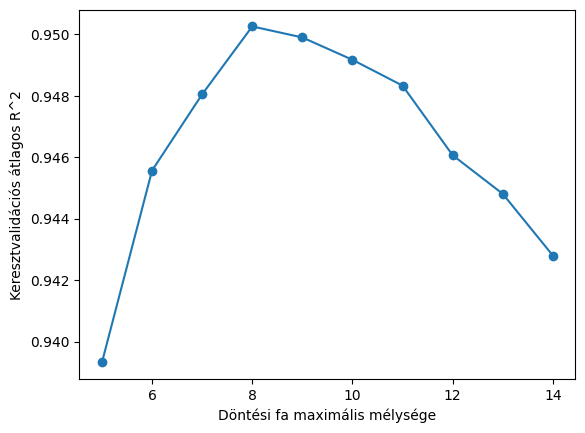

In [27]:
# plot the best R2 score for each max_depth
plt.plot(dt_results_map_r2_cv.keys(), dt_results_map_r2_cv.values(), marker='o')
plt.xlabel('Döntési fa maximális mélysége')
plt.ylabel('Keresztvalidációs átlagos R^2')

# get Best Decision tree max_depth from dt_results_map_r2_cv
def get_best_max_depth():
    best_max_depth = 0
    best_max_depth_value = 0
    for max_depth, value in dt_results_map_r2_cv.items():
        if value.values[0] > best_max_depth_value:
            best_max_depth = max_depth
            best_max_depth_value = value.values[0]

    return best_max_depth, best_max_depth_value

best_max_depth, best_max_depth_value = get_best_max_depth()
best_max_depth, best_max_depth_value




In [28]:
# calculate Decesion Tree regression with with best max depth
df_results_dt_best = decision_tree_regression_all(input_sets, best_max_depth)
df_results = pd.concat([df_results, df_results_dt_best], ignore_index=True)

C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\2229240700.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_dt = pd.concat([df_results_dt, dt_res], ignore_index=True)


### Random Forest regression

The remaining models take more time to run, so I only use the best performing datasets. Based on the previous regressions, the best performing models are:
* AT_V_AP
* Full

In [30]:
best_input_sets = [
    {'train': df_train_AT_V_AP, 'test': df_test_AT_V_AP, 'name': 'AT_V_AP'},
    {'train': df_train_X, 'test': df_test_X, 'name': 'Full'}
]

best_input_sets_sc = [
    {'train': df_train_AT_V_AP_sc, 'test': df_test_AT_V_AP_sc, 'name': 'AT_V_AP_sc'},
    {'train': df_train_X_sc, 'test': df_test_X_sc, 'name': 'Full_sc'}
]

In [29]:
# function of Random Forest regression for an input set
from sklearn.ensemble import RandomForestRegressor

def random_forest_regression(input_set: dict, n_estimators: int):
    df_train_rf = input_set['train']
    df_test_rf = input_set['test']

    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    rf.fit(df_train_rf, df_train_y)

    df_train_y_rf_pred = rf.predict(df_train_rf)
    df_test_y_rf_pred = rf.predict(df_test_rf)

    rf_result = {
        'model': f'Random Forest Regression (n_estimators={n_estimators})',
        'input': input_set['name'],
        'R2_train': r2_score(df_train_y, df_train_y_rf_pred),
        'R2_test': r2_score(df_test_y, df_test_y_rf_pred),
        'RMSE_train': math.sqrt(mean_squared_error(df_train_y, df_train_y_rf_pred)),
        'RMSE_test': math.sqrt(mean_squared_error(df_test_y, df_test_y_rf_pred)),
        'MAE_train': mean_absolute_error(df_train_y, df_train_y_rf_pred),
        'MAE_test': mean_absolute_error(df_test_y, df_test_y_rf_pred)
    }

    return pd.DataFrame([rf_result])

# function for Random Forest regression for all input sets
def random_forest_regression_all(input_sets: list, n_estimators: int):
    df_results_rf = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

    for input_set in input_sets:
        rf_res = random_forest_regression(input_set, n_estimators)
        df_results_rf = pd.concat([df_results_rf, rf_res], ignore_index=True)

    return df_results_rf


In [31]:
# function for Random forest regression with cross-validation
def random_forest_regression_cv(input_set: dict, n_estimators: int):
    df_train_rf = input_set['train']
    df_test_rf = input_set['test']

    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=0)

    # Perform cross-validation
    scores = cross_val_score(rf, df_train_rf, df_train_y, cv=5, scoring='r2')

    rf_result_cv = {
        'model': f'Random Forest Regression CV (n_estimators={n_estimators})',
        'input': input_set['name'],
        'R2_mean': scores.mean(),
        'R2_std': scores.std(),
    }

    return pd.DataFrame([rf_result_cv])

# function for Random Forest regression with cross-validation for all input sets
def random_forest_regression_cv_all(input_sets: list, n_estimators: int):
    df_results_rf_cv = pd.DataFrame(columns=['model', 'input', 'R2_mean', 'R2_std'])

    for input_set in input_sets:
        rf_res_cv = random_forest_regression_cv(input_set, n_estimators)
        df_results_rf_cv = pd.concat([df_results_rf_cv, rf_res_cv], ignore_index=True)

    return df_results_rf_cv

In [34]:
# for n_estimators in range(15, 46, 10) do Random Forest regression with cross-validation for all input sets
rf_results_map_r2_cv = {}
rf_results_map_cv = {}
for n_estimators in range(45, 76, 10):
    rf_res_cv = random_forest_regression_cv_all(best_input_sets, n_estimators)
    best_rf_res_cv = get_max_r2_cv(rf_res_cv)
    rf_results_map_cv[n_estimators] = best_rf_res_cv
    best_r2_cv = best_rf_res_cv['R2_mean']
    rf_results_map_r2_cv[n_estimators] = best_r2_cv


c:\repos\pannon-mi-beadando1\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\repos\pannon-mi-beadando1\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\repos\pannon-mi-beadando1\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\repos\pannon-mi-beadando1\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

(75, 0.9669505497652316)

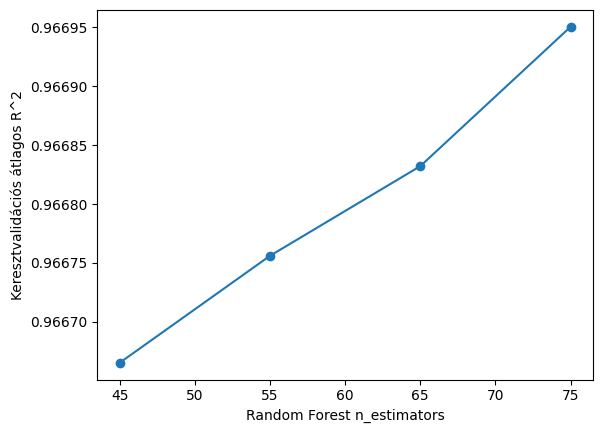

In [41]:
# plot the best R2 score for each n_estimators
plt.plot(rf_results_map_r2_cv.keys(), rf_results_map_r2_cv.values(), marker='o')
plt.xlabel('Random Forest n_estimators')
plt.ylabel('Keresztvalidációs átlagos R^2')

# get Best Random Forest n_estimators from rf_results_map_r2_cv
def get_best_n_estimators():
    best_n_estimators = 0
    best_n_estimators_value = 0
    for n_estimators, value in rf_results_map_r2_cv.items():
        if value.values[0] > best_n_estimators_value:
            best_n_estimators = n_estimators
            best_n_estimators_value = value.values[0]

    return best_n_estimators, best_n_estimators_value

# get the best input set for Random Forest based on rf_results_map_cv
def get_best_input_set_for_random_forest():
    best_rf_res_cv = get_max_r2_cv(rf_results_map_cv[best_n_estimators])
    best_input_set_name = best_rf_res_cv['input'].values[0]
    if best_input_set_name.endswith('_sc'):
        selected_input_set = next(item for item in input_sets_sc if item['name'] == best_input_set_name)
    else:
        selected_input_set = next(item for item in input_sets if item['name'] == best_input_set_name)
    return selected_input_set

best_n_estimators, best_n_estimators_value = get_best_n_estimators()
best_input_set_for_random_forest = get_best_input_set_for_random_forest()
best_n_estimators, best_n_estimators_value

In [42]:
# calculate Random Forest regression with with best n_estimators and best input set
df_result_rf_best = random_forest_regression(best_input_set_for_random_forest, best_n_estimators)
df_results = pd.concat([df_results, df_result_rf_best], ignore_index=True)

c:\repos\pannon-mi-beadando1\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Support Vector regression

Az SVR regresszió érzékeny a független változók nagyságrendi különbségeire, így a sztenderdizált adatsorokkal dolgozom.


In [51]:
# function of Support Vector Machine regression for an input set
from sklearn.svm import SVR

def svr_regression(input_set: dict, kernel: str):
    df_train_svr = input_set['train']
    df_test_svr = input_set['test']

    svr = SVR(kernel=kernel)
    svr.fit(df_train_svr, df_train_y.values.ravel())

    df_train_y_svr_pred = svr.predict(df_train_svr)
    df_test_y_svr_pred = svr.predict(df_test_svr)

    svr_result = {
        'model': f'Support Vector Machine Regression (kernel={kernel})',
        'input': input_set['name'],
        'R2_train': r2_score(df_train_y, df_train_y_svr_pred),
        'R2_test': r2_score(df_test_y, df_test_y_svr_pred),
        'RMSE_train': math.sqrt(mean_squared_error(df_train_y, df_train_y_svr_pred)),
        'RMSE_test': math.sqrt(mean_squared_error(df_test_y, df_test_y_svr_pred)),
        'MAE_train': mean_absolute_error(df_train_y, df_train_y_svr_pred),
        'MAE_test': mean_absolute_error(df_test_y, df_test_y_svr_pred)
    }

    return pd.DataFrame([svr_result])

# function for poly-kernel Support Vector Machine regression for degree
def svr_regression_poly(input_set: dict, degree: int):
    df_train_svr = input_set['train']
    df_test_svr = input_set['test']

    svr = SVR(kernel='poly', degree=degree)
    svr.fit(df_train_svr, df_train_y.values.ravel())

    df_train_y_svr_pred = svr.predict(df_train_svr)
    df_test_y_svr_pred = svr.predict(df_test_svr)

    svr_result = {
        'model': f'Support Vector Machine Regression (kernel=poly, degree={degree})',
        'input': input_set['name'],
        'R2_train': r2_score(df_train_y, df_train_y_svr_pred),
        'R2_test': r2_score(df_test_y, df_test_y_svr_pred),
        'RMSE_train': math.sqrt(mean_squared_error(df_train_y, df_train_y_svr_pred)),
        'RMSE_test': math.sqrt(mean_squared_error(df_test_y, df_test_y_svr_pred)),
        'MAE_train': mean_absolute_error(df_train_y, df_train_y_svr_pred),
        'MAE_test': mean_absolute_error(df_test_y, df_test_y_svr_pred)
    }

    return pd.DataFrame([svr_result])

# function for Support Vector Machine regression for all input sets
def svr_regression_all(input_sets: list, kernel: str):
    df_results_svr = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])

    for input_set in input_sets:
        svr_res = svr_regression(input_set, kernel)
        df_results_svr = pd.concat([df_results_svr, svr_res], ignore_index=True)

    return df_results_svr


In [44]:
# calculate Support Vector Machine regression on best input sets for linear, poly and rbf kernels
df_results_svr_linear = svr_regression_all(best_input_sets, 'linear')
df_results_svr_linear_sc = svr_regression_all(best_input_sets_sc, 'linear')

C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\1485281677.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_svr = pd.concat([df_results_svr, svr_res], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\1485281677.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_svr = pd.concat([df_results_svr, svr_res], ignore_index=True)


In [45]:
# function for poly-kernel Support Vector regression with cross-validation
def svr_poly_regression_cv(input_set: dict, degree: int):
    df_train_svr = input_set['train']
    df_test_svr = input_set['test']

    svr = SVR(kernel='poly', degree=degree)

    # Perform cross-validation
    scores = cross_val_score(svr, df_train_svr, df_train_y.values.ravel(), cv=5, scoring='r2')

    svr_result_cv = {
        'model': f'Support Vector Machine Regression CV (kernel=poly, degree={degree})',
        'input': input_set['name'],
        'R2_mean': scores.mean(),
        'R2_std': scores.std(),
    }

    return pd.DataFrame([svr_result_cv])

# function for poly-kernel Support Vector regression with cross-validation for all input sets
def svr_regression_cv_all(input_sets: list, degree: int):
    df_results_svr_cv = pd.DataFrame(columns=['model', 'input', 'R2_mean', 'R2_std'])

    for input_set in input_sets:
        svr_res_cv = (input_set, degree)
        df_results_svr_cv = pd.concat([df_results_svr_cv, svr_res_cv], ignore_index=True)

    return df_results_svr_cv


In [46]:
# for degree in range(5, 18, 3) do poly-kernel Support Vector regression with cross-validation for best input sets
svr_poly_results_map_r2_cv = {}
svr_poly_results_map_cv = {}
for degree in range(5, 18, 3):
    svr_res_cv = svr_regression_cv_all(best_input_sets, degree)
    best_svr_res_cv = get_max_r2_cv(svr_res_cv)
    svr_poly_results_map_cv[degree] = best_svr_res_cv
    best_r2_cv = best_svr_res_cv['R2_mean']
    svr_poly_results_map_r2_cv[degree] = best_r2_cv


C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\3400093394.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_svr_cv = pd.concat([df_results_svr_cv, svr_res_cv], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\3400093394.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_svr_cv = pd.concat([df_results_svr_cv, svr_res_cv], ignore_index=True)
C:\Users\lobon\AppData\Local\Temp\ipykernel_34668\3400093394.py:26: FutureWarning: The behavior of DataFrame

(14, 0.9335104144548361)

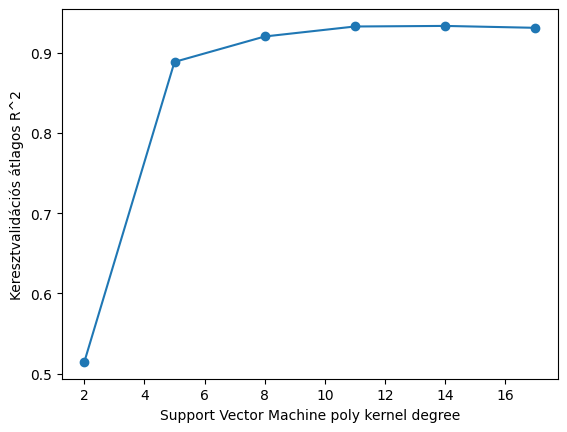

In [47]:
# plot the best R2 score for each degree
plt.plot(svr_poly_results_map_r2_cv.keys(), svr_poly_results_map_r2_cv.values(), marker='o')
plt.xlabel('Support Vector Machine poly kernel degree')
plt.ylabel('Keresztvalidációs átlagos R^2')

# get Best Support Vector Machine poly kernel degree from svr_poly_results_map_r2_cv
def get_best_degree():
    best_degree = 0
    best_degree_value = 0
    for degree, value in svr_poly_results_map_r2_cv.items():
        if value.values[0] > best_degree_value:
            best_degree = degree
            best_degree_value = value.values[0]

    return best_degree, best_degree_value

# get best input set for Support Vector Machine poly kernel based on svr_poly_results_map_cv
def get_best_input_set_for_svr_poly():
    best_svr_res_cv = get_max_r2_cv(svr_poly_results_map_cv[best_degree])
    best_input_set_name = best_svr_res_cv['input'].values[0]
    if best_input_set_name.endswith('_sc'):
        selected_input_set = next(item for item in input_sets_sc if item['name'] == best_input_set_name)
    else:
        selected_input_set = next(item for item in input_sets if item['name'] == best_input_set_name)
    return selected_input_set

best_degree, best_degree_value = get_best_degree()
best_degree, best_degree_value

In [52]:
# calculate Support Vector Machine poly kernel regression with with best degree and best input set
best_input_set_for_svr_poly = get_best_input_set_for_svr_poly()
df_result_svr_poly_best = svr_regression_poly(best_input_set_for_svr_poly, best_degree)
df_results = pd.concat([df_results, df_result_svr_poly_best], ignore_index=True)

### Neural Network
Neurális háló esetében fontos, hogy a bemeneti adatok skálázva legyenek. Bemenetként az eddig legjobban teljesítő skálázott adatsort használom: Full_sc

Struktúra:
Szekvenciális neurális hálót használok teljesen összekapcsolt rétegekkel.
Bemeneti réteg dimenziója: 4 (a független változók száma)
Kimeneti réteg dimenziója: 1 (a függő változók száma)

A rejtett rétegekben ReLu aktivációs függvénnyel viszek nemlinearitást a hálóba, a kimeneti rétegben pedig a regressziós feladatnak megfelelően lineáris aktivációs függvényt használok. 


In [126]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

scaler_y = StandardScaler()
df_train_y_sc = scaler_y.fit_transform(df_train_y)
df_test_y_sc = scaler_y.transform(df_test_y)

# function of NN regression
def nn_regression(layers_dim: int):
    input_set_nn = best_input_sets_sc[1] # Full input set
    df_train_nn = input_set_nn['train']
    df_test_nn = input_set_nn['test']

    model = tf.keras.Sequential()
    model.add(Input(shape=(df_train_nn.shape[1],)))
    model.add(Dense(layers_dim, activation='relu'))
    model.add(Dense(layers_dim, activation='relu'))
    model.add(Dense(layers_dim, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(df_train_nn, df_train_y_sc, epochs=100, validation_split=0.2)

    y_pred_train_NN_sc = model.predict(df_train_nn)
    y_pred_train_NN = scaler_y.inverse_transform(y_pred_train_NN_sc)
    y_pred_test_NN_sc = model.predict(df_test_nn)
    y_pred_test_NN = scaler_y.inverse_transform(y_pred_test_NN_sc)

    nn_result = {
        'model': f'Neural Network, layers_dim={layers_dim}',
        'input': input_set['name'],
        'R2_train': r2_score(df_train_y, y_pred_train_NN),
        'R2_test': r2_score(df_test_y, y_pred_test_NN),
        'RMSE_train': math.sqrt(mean_squared_error(df_test_y, y_pred_NN)),
        'RMSE_test': math.sqrt(mean_squared_error(df_test_y, y_pred_NN)),
        'MAE_train': mean_absolute_error(df_test_y, y_pred_NN),
        'MAE_test': mean_absolute_error(df_test_y, y_pred_NN)
    }

    return pd.DataFrame([nn_result])

# calculate NN regression for 4, 7, 10 neurons
df_results_nn = pd.DataFrame(columns=['model', 'input', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAE_train', 'MAE_test'])
for layers_dim in [4, 7, 10]:
    nn_res = nn_regression(layers_dim)
    df_results_nn = pd.concat([df_results_nn, nn_res], ignore_index=True)



Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9234 - val_loss: 0.3528
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2334 - val_loss: 0.0927
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0869 - val_loss: 0.0776
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0742 - val_loss: 0.0733
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0687 - val_loss: 0.0709
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0661 - val_loss: 0.0691
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0654 - val_loss: 0.0678
Epoch 8/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0619 - val_loss: 0.0670
Epoch 9/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0637 - val_loss: 0.0638
Epoch 10/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0622 - val_loss: 0.0631
Epoch 11/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0600 - val_loss: 0.0620
Epoch 12/100
211/211 ━━━━━━━━━━━━━━━━━━━━

C:\Users\lobon\AppData\Local\Temp\ipykernel_15128\2356376671.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_nn = pd.concat([df_results_nn, nn_res], ignore_index=True)


211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5659 - val_loss: 0.0983
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0893 - val_loss: 0.0696
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0677 - val_loss: 0.0634
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0619 - val_loss: 0.0609
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0617 - val_loss: 0.0593
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0593 - val_loss: 0.0579
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0571 - val_loss: 0.0574
Epoch 8/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0568 - val_loss: 0.0565
Epoch 9/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0572 - val_loss: 0.0561
Epoch 10/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0575 - val_loss: 0.0557
Epoch 11/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0559 - val_loss: 0.0555
Epoch 12/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

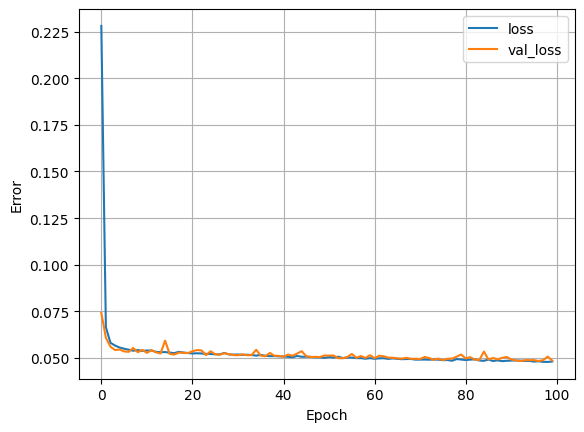

In [127]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)


In [128]:


display(pd.DataFrame([nn_results]))


model input  R2_train  R2_test  RMSE_train  RMSE_test  MAE_train  \
0  Neural Network  Full  0.952502  0.94564    3.866306   3.866306   2.932567   

   MAE_test  
0  2.932567

## Results

 - Do y_predicted - y Plots